# Evaluation of RCMs in terms of icclim indicators

In [1]:
## Tested using the following loaded modules
## module use /g/data/access/ngm/modules
## module load analysis3/21.10
import os, sys
workdir = "/g/data/tp28/dev/chs548/BARPA_evaluation/chs"
os.chdir(workdir)
sys.path.append("../lib")
import glob
import xarray as xr
import numpy as np
from datetime import datetime as dt
import lib_standards
import matplotlib as mpl
import matplotlib.pyplot as plt
import importlib
importlib.reload(lib_standards)
import warnings
warnings.filterwarnings('ignore')

font = {'size'   : 12}
mpl.rc('font', **font)

## Configurations

In [2]:
DATA_LOCATIONS = {
    'AGCD': "/g/data/ia39/australian-climate-service/test-data/CORDEX-CMIP6/indices/AUS-r005/none/BOM-AGCD/historical/none/none/v1/climdex",
    'BARPA-R:ERA5': "/g/data/ia39/australian-climate-service/test-data/CORDEX-CMIP6/indices/AUS-15/BOM/ECMWF-ERA5/evaluation/r1i1p1f1/BOM-BARPA-R/v1/climdex",
    'ERA5': "/g/data/ia39/australian-climate-service/test-data/CORDEX-CMIP6/indices/AUS-25/none/ECMWF-ERA5/historical/none/none/v1/climdex"
}
# Frequency of icclim indicator
FREQ = 'month'
# Data sources to consider here
SOURCES = ['BARPA-R:ERA5', 'AGCD', 'ERA5']
# Grid to used as the reference grid to compute difference metrics
REFERENCE_GRID = 'BARPA-R:ERA5'
# "Truth" for compute difference metrics
REFERENCE = 'AGCD'
# Region of interest, as per defined in lib_standards.DOMAINS
REGION = 'Australia'  
# Period of interest, as per defined in lib_standards.PERIODS
PERIOD = 'HISTORICAL_WHOLE' 
# Individual subregions to compute metrics
SUBREGIONS = lib_standards.get_nrm_names()
# Difference metrics, as per defined in lib_standards.compute_score()
# METRICS = ['RMSE', 'Additive_Bias', 'Multiplicative_Bias', 'Correlation', 'Additive_Bias:DJF', 'Additive_Bias:JJA', 'Correlation:ClimMon']
# METRICS = ['Additive_Bias:DJF', 'Additive_Bias:JJA', 'Correlation:ClimMonth']
# Two periods for compute change as per defined in lib_standards.PERIODS
EARLYPERIOD = "HISTORICAL_EARLY"
LATEPERIOD = "HISTORICAL_LATE" 
# Season of interest, as per defined in lib_standards.SEASONS
# default season, unless specified otherwise in the METRICS
SEASON = 'all'
# icclim indicators to consider here
#INDEXES = ['TX', 'SU', 'TXx', 'TXn',
#           'TN', 'TR', 'TNx', 'FD', 'TNn',
#           'PRCPTOT', 'RR1', 'RR', 'R10mm', 'R20mm', 'RX1day', 'RX5day']
INDEXES = ['SU', 'TXx', 'TXn',
           'TR', 'TNx', 'TNn',
           'RR1', 'R10mm', 'RX1day']
# SU, TXx, TXn, TR, TNx, TNn
# R10mm, RX1day, RR1 or RR?

In [3]:
def prepare_data(index, sources=SOURCES, freq=FREQ, 
                 region=REGION, period=PERIOD, reference_grid=REFERENCE_GRID, season=SEASON,
                 apply_agcd_data_mask=False):
    """
    Reads in the icclim data and regrid to the reference grid.
    """
    # Load the data sources
    ds = {}
    for s in sources:
        print("Reading the data {:}".format(s))
        fs = glob.glob(os.path.join(DATA_LOCATIONS[s], index, "{index}_*_{freq}_*.nc".format(index=index, freq=freq)))
        ds[s] = xr.open_dataset(fs[0])
        ds[s] = lib_standards.standardise_data(ds[s], region=region, period=period, season=season, compute=True)
        
    # Regrid to the REFERENCE_GRID
    ds_regrid = {}
    for s in sources:
        print("Regridding the data {:} to reference grid of {:}".format(s, reference_grid))
        ds_regrid[s] = lib_standards.add_region_land_mask(ds[s], region)
        if s == reference_grid:
            ds_regrid[s] = ds_regrid[s].compute()
        else:
            ds_regrid[s] = lib_standards.regrid(ds_regrid[s], ds[reference_grid]).compute()
            
        ds_regrid[s] = lib_standards.apply_region_mask(ds_regrid[s], region)
        if apply_agcd_data_mask:
            ds_regrid[s] = lib_standards.apply_agcd_data_mask(ds_regrid[s])
            
    return ds_regrid
                                                                 
def compute_difference_metrics(index, metric, ds, subregions=SUBREGIONS, reference=REFERENCE, aggregator='mean', dim='time'):
    """
    Computes the difference metrics for all the data (assumed already regridded to a common 
    reference grid), for each subregions.
    """
    scorecards = {}
    for source in ds.keys():
        # For each data source
        if source == reference:
            continue

        scorecards[source] = {}
        # Compute the difference metric against the reference data over the whole domain
        score = lib_standards.compute_score(ds[reference][index], ds[source][index], metric, dims=dim)
                       
        # Aggregate the metric values over subregions
        for subregion in subregions:
            mean_score = lib_standards.region_aggregation(score, aggregator, subregion)
            scorecards[source][subregion] = float(mean_score)
                       
    return scorecards

def compute_change_metric(index, ds, subregions=SUBREGIONS, 
                          reference=REFERENCE, aggregator='mean', 
                          earlyperiod=EARLYPERIOD, lateperiod=LATEPERIOD):
    """
    Computes the change metrics for all the data (assumed already regridded to a common 
    reference grid), for each subregions.
    """
    changes = {}
    for source in ds.keys():
        # For each data source
        
        changes[source] = {}
        # Compute the change delta between two time periods of the timeseries
        change = lib_standards.compute_change(ds[source][index], dims='time', earlyperiod=earlyperiod, lateperiod=lateperiod)
        
        # Aggregate the change values over subregions
        for subregion in subregions:
            mean_change = lib_standards.region_aggregation(change, aggregator, subregion)
            changes[source][subregion] = float(mean_change)
                       
    return changes

def apply_metric_condition(ds, index, metric, freq=FREQ):
    
    # check whether the metric has special conditions
    metric_condition = None
    if not ":" in metric:
        label = "{metric} for {index}({freq})".format(metric=metric_name, freq=freq, index=index)
        ds_target = ds
        dim = 'time'
        metric_name = metric
    else:
        metric_condition = metric.split(":")[1]
        metric_name = metric.split(":")[0]
        
        ds_target = {}
        if metric_condition in ['DJF', 'MAM', 'JJA', 'SON']:
            # Only use data for the selected seasons
            for s in ds.keys():
                ds_target[s] = ds[s].sel(time=ds[s].time.dt.month.isin(lib_standards.SEASONS[metric_condition]))
            label = "{metric} for {index}({metric_condition})".format(metric=metric_name, metric_condition=metric_condition, index=index)
            dim = 'time'
        elif metric_condition == 'ClimMon':
            # Convert to climatological monthly averages
            for s in ds.keys():
                ds_target[s] = ds[s].groupby("time.month").mean(dim="time")
            label = "{metric} for {index}(clim month mean)".format(metric=metric_name, index=index)
            dim = 'month'
        else:
            assert False, "Undefined metric condition: {:}".format(metric_condition)
            
    return ds_target, metric_name, dim, label

## Compare icclim indicator values between model and a given reference using difference metrics

In [ ]:
# Difference metrics, as per defined in lib_standards.compute_score()
METRICS = ['RMSE', 'Additive_Bias', 'Multiplicative_Bias', 'Correlation']
for index in INDEXES:
    # Prepare all the icclim data as per the setup in CONFIGURATIONS
    print("index = {:}".format(index))
    ds = prepare_data(index.lower())
    
    fig_xy = (1, len(METRICS))
    fig = plt.figure(figsize=(15, 5))
    for i, metric in enumerate(METRICS):
        #print(" --> {:}".format(metric))
        
        # check whether the index has special conditions
        metric_condition = None
        if not ":" in metric:
            clabel = "{metric} for {index}({freq})".format(metric=metric, freq=FREQ, index=index)
            ds_target = ds
            dim = 'time'
        else:
            metric_condition = metric.split(":")[1]
            metric = metric.split(":")[0]
        
            ds_target = {}
            if metric_condition in ['DJF', 'MAM', 'JJA', 'SON']:
                # Only use data for the selected seasons
                for s in ds.keys():
                    ds_target[s] = ds[s].sel(time=ds[s].time.dt.month.isin(lib_standards.SEASONS[metric_condition]))
                clabel = "{metric} for {index}({metric_condition})".format(metric=metric, metric_condition=metric_condition, index=index)
                dim = 'time'
            elif metric_condition == 'ClimMon':
                # Convert to climatological monthly averages
                for s in ds.keys():
                    ds_target[s] = ds[s].groupby("time.month").mean(dim="time")
                clabel = "{metric} for {index}(clim month mean)".format(metric=metric, index=index)
                dim = 'month'
            else:
                assert False, "Undefined metric condition: {:}".format(metric_condition)
        
        # Compute difference metrics as per the setup in CONFIGURATIONS
        scorecards = compute_difference_metrics(index, metric, ds_target, dim=dim)
        
        ax = plt.subplot(fig_xy[0], fig_xy[1], i+1)

        add_xticklabels = False
        add_yticklabels = False
        if i in [0]:
            add_yticklabels = True
        if i in [0, 1, 2, 3, 4, 5, 6, 7]:
            add_xticklabels = True
            
        vmin = None
        vmax = None
        if index in ['RX1day', 'RX5day', 'RR'] and metric == 'Multiplicative_Bias':
            vmax = 2
            vmin = -vmax
        if index in ['PRCPTOT'] and metric == 'Multiplicative_Bias':
            vmax = 0.5
            vmin = -vmax

        lib_standards.table_plot(ax, scorecards, 
                clabel=clabel, vmin=vmin, vmax=vmax,
                add_xticklabels=add_xticklabels,
                add_yticklabels=add_yticklabels,
                xrotation=90)
    
    plt.subplots_adjust(wspace=0.4)

## For the main paper: Repeat the temperature-related metrics but for specific months namely DJF and JJA

index = SU
Reading the data BARPA-R:ERA5
Reading the data AGCD
Reading the data ERA5
Regridding the data BARPA-R:ERA5 to reference grid of BARPA-R:ERA5
Regridding the data AGCD to reference grid of BARPA-R:ERA5
Regridding the data ERA5 to reference grid of BARPA-R:ERA5
index = TXx
Reading the data BARPA-R:ERA5
Reading the data AGCD
Reading the data ERA5
Regridding the data BARPA-R:ERA5 to reference grid of BARPA-R:ERA5
Regridding the data AGCD to reference grid of BARPA-R:ERA5
Regridding the data ERA5 to reference grid of BARPA-R:ERA5
index = TXn
Reading the data BARPA-R:ERA5
Reading the data AGCD
Reading the data ERA5
Regridding the data BARPA-R:ERA5 to reference grid of BARPA-R:ERA5
Regridding the data AGCD to reference grid of BARPA-R:ERA5
Regridding the data ERA5 to reference grid of BARPA-R:ERA5
index = TR
Reading the data BARPA-R:ERA5
Reading the data AGCD
Reading the data ERA5
Regridding the data BARPA-R:ERA5 to reference grid of BARPA-R:ERA5
Regridding the data AGCD to referenc

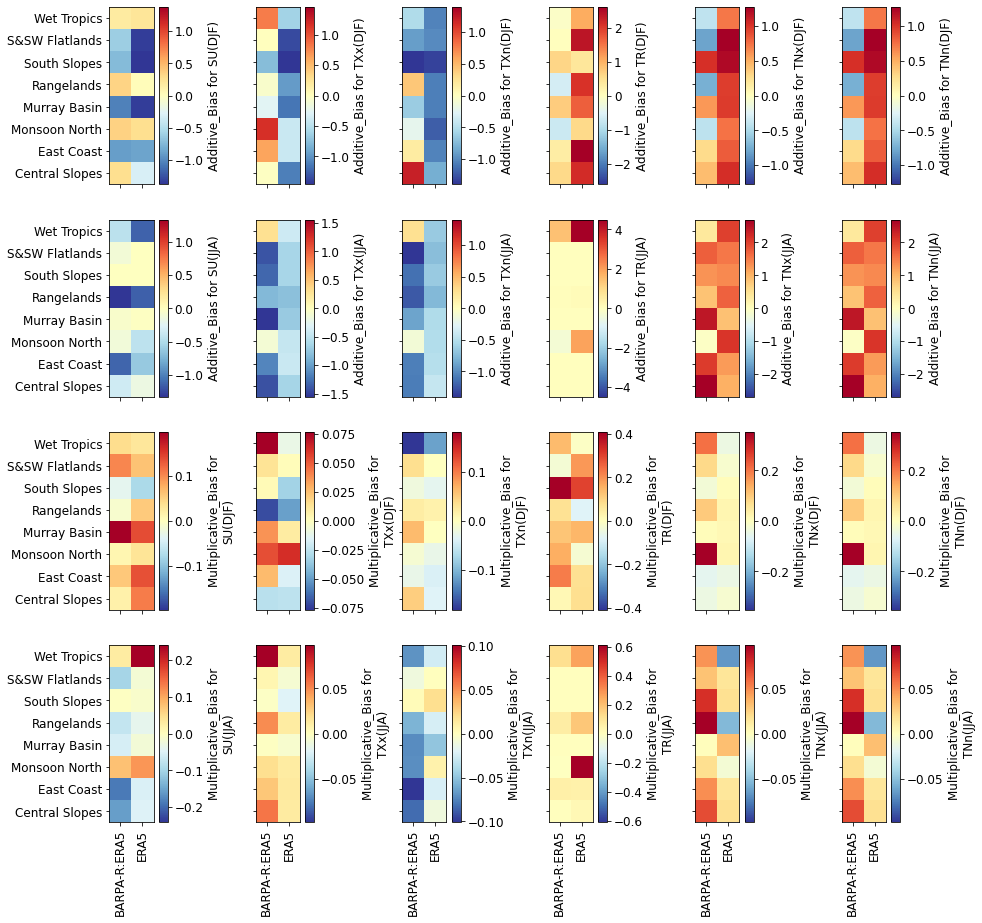

In [81]:
# Difference metrics, as per defined in lib_standards.compute_score()
#METRICS = ['Correlation:ClimMon']
METRICS = ['Additive_Bias:DJF', 'Additive_Bias:JJA', 'Multiplicative_Bias:DJF', 'Multiplicative_Bias:JJA']
INDEXES = ['SU', 'TXx', 'TXn',
           'TR', 'TNx', 'TNn']
cmap_variable = 'temp'
cmap_class = 'hot_diff'

fig_xy = (len(METRICS), len(INDEXES))
fig = plt.figure(figsize=(15, 15))

for j, index in enumerate(INDEXES):
    # Prepare all the icclim data as per the setup in CONFIGURATIONS
    print("index = {:}".format(index))
    ds = prepare_data(index.lower())
    
    for i, metric in enumerate(METRICS):
        #print(" --> {:}".format(metric))
        
        ds_target, metric_name, dim, clabel = apply_metric_condition(ds, index, metric)
        
        # Compute difference metrics as per the setup in CONFIGURATIONS
        scorecards = compute_difference_metrics(index, metric_name, ds_target, dim=dim)
        
        ax = plt.subplot(fig_xy[0], fig_xy[1], i*len(INDEXES)+j+1)

        add_xticklabels = False
        add_yticklabels = False
        if j == 0:
            add_yticklabels = True
        if i == len(METRICS)-1:
            add_xticklabels = True

        lib_standards.table_plot(ax, scorecards, 
                clabel=clabel,
                add_xticklabels=add_xticklabels,
                add_yticklabels=add_yticklabels,
                xrotation=90,
                cmap_variable=cmap_variable, cmap_class=cmap_class)
    
    plt.subplots_adjust(wspace=0.4)

## For the main paper: Repeat the rainfall-related metrics but for specific months namely DJF and JJA

index = RR1
Reading the data BARPA-R:ERA5
Reading the data AGCD
Reading the data ERA5
Regridding the data BARPA-R:ERA5 to reference grid of BARPA-R:ERA5
Regridding the data AGCD to reference grid of BARPA-R:ERA5
Regridding the data ERA5 to reference grid of BARPA-R:ERA5
index = R10mm
Reading the data BARPA-R:ERA5
Reading the data AGCD
Reading the data ERA5
Regridding the data BARPA-R:ERA5 to reference grid of BARPA-R:ERA5
Regridding the data AGCD to reference grid of BARPA-R:ERA5
Regridding the data ERA5 to reference grid of BARPA-R:ERA5
index = RX1day
Reading the data BARPA-R:ERA5
Reading the data AGCD
Reading the data ERA5
Regridding the data BARPA-R:ERA5 to reference grid of BARPA-R:ERA5
Regridding the data AGCD to reference grid of BARPA-R:ERA5
Regridding the data ERA5 to reference grid of BARPA-R:ERA5


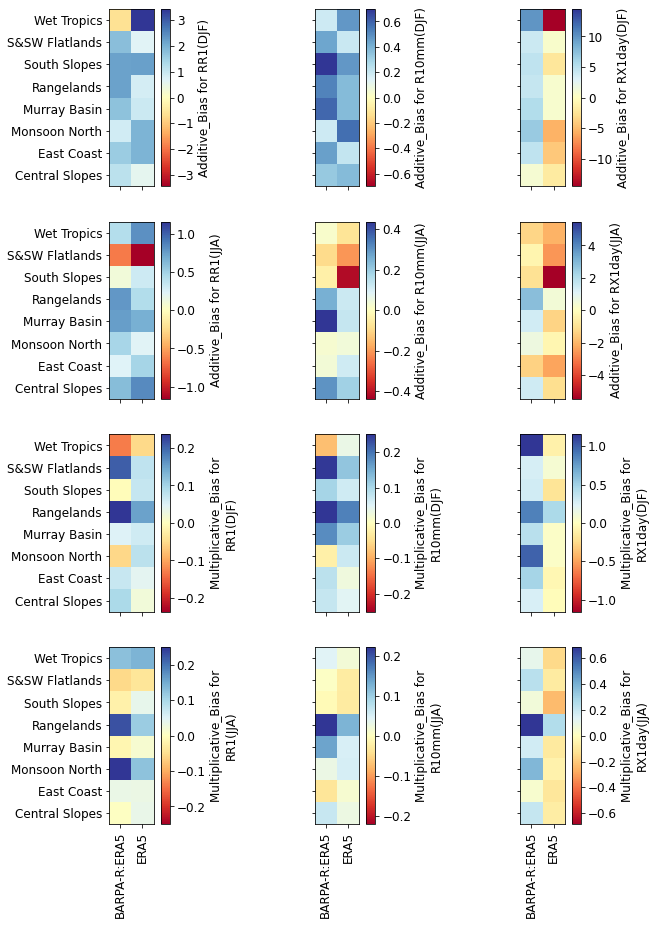

In [83]:
# Difference metrics, as per defined in lib_standards.compute_score()
#METRICS = ['Correlation:ClimMon']
METRICS = ['Additive_Bias:DJF', 'Additive_Bias:JJA', 'Multiplicative_Bias:DJF', 'Multiplicative_Bias:JJA']
INDEXES = ['RR1', 'R10mm', 'RX1day']
cmap_variable = 'precip'
cmap_class = 'wet_diff'
importlib.reload(lib_standards)

fig_xy = (len(METRICS), len(INDEXES))
fig = plt.figure(figsize=(10, 15))

for j, index in enumerate(INDEXES):
    # Prepare all the icclim data as per the setup in CONFIGURATIONS
    print("index = {:}".format(index))
    ds = prepare_data(index.lower(), apply_agcd_data_mask=True)
    
    for i, metric in enumerate(METRICS):
        #print(" --> {:}".format(metric))
        
        ds_target, metric_name, dim, clabel = apply_metric_condition(ds, index, metric)
        
        # Compute difference metrics as per the setup in CONFIGURATIONS
        scorecards = compute_difference_metrics(index, metric_name, ds_target, dim=dim)
        
        ax = plt.subplot(fig_xy[0], fig_xy[1], i*len(INDEXES)+j+1)

        add_xticklabels = False
        add_yticklabels = False
        if j == 0:
            add_yticklabels = True
        if i == len(METRICS)-1:
            add_xticklabels = True

        lib_standards.table_plot(ax, scorecards, 
                clabel=clabel,
                add_xticklabels=add_xticklabels,
                add_yticklabels=add_yticklabels,
                xrotation=90,
                cmap_variable=cmap_variable, cmap_class=cmap_class)
    
    plt.subplots_adjust(wspace=0.4)

## Repeat the temperature-related metrics but for specific months namely MAM and SON (Supplementary)

index = SU
Reading the data BARPA-R:ERA5
Reading the data AGCD
Reading the data ERA5
Regridding the data BARPA-R:ERA5 to reference grid of BARPA-R:ERA5
Regridding the data AGCD to reference grid of BARPA-R:ERA5
Regridding the data ERA5 to reference grid of BARPA-R:ERA5
index = TXx
Reading the data BARPA-R:ERA5
Reading the data AGCD
Reading the data ERA5
Regridding the data BARPA-R:ERA5 to reference grid of BARPA-R:ERA5
Regridding the data AGCD to reference grid of BARPA-R:ERA5
Regridding the data ERA5 to reference grid of BARPA-R:ERA5
index = TXn
Reading the data BARPA-R:ERA5
Reading the data AGCD
Reading the data ERA5
Regridding the data BARPA-R:ERA5 to reference grid of BARPA-R:ERA5
Regridding the data AGCD to reference grid of BARPA-R:ERA5
Regridding the data ERA5 to reference grid of BARPA-R:ERA5
index = TR
Reading the data BARPA-R:ERA5
Reading the data AGCD
Reading the data ERA5
Regridding the data BARPA-R:ERA5 to reference grid of BARPA-R:ERA5
Regridding the data AGCD to referenc

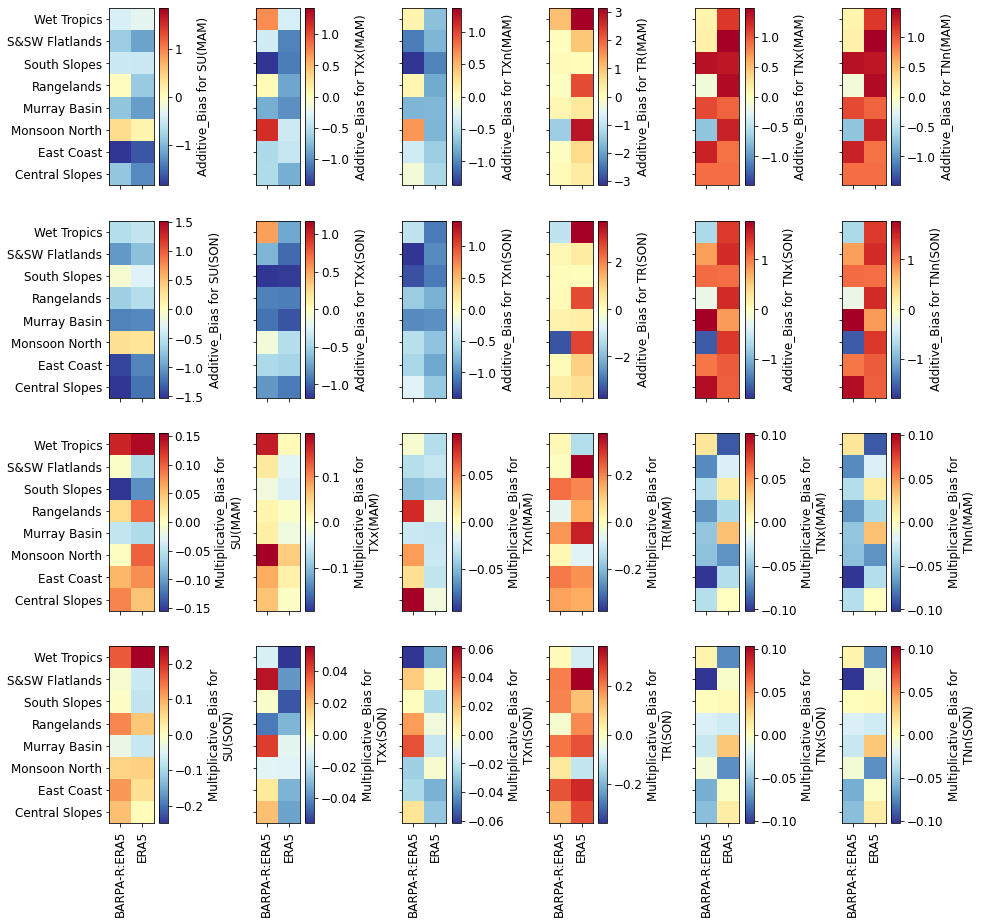

In [4]:
# Difference metrics, as per defined in lib_standards.compute_score()
#METRICS = ['Correlation:ClimMon']
METRICS = ['Additive_Bias:MAM', 'Additive_Bias:SON', 'Multiplicative_Bias:MAM', 'Multiplicative_Bias:SON']
INDEXES = ['SU', 'TXx', 'TXn',
           'TR', 'TNx', 'TNn']
cmap_variable = 'temp'
cmap_class = 'hot_diff'

fig_xy = (len(METRICS), len(INDEXES))
fig = plt.figure(figsize=(15, 15))

importlib.reload(lib_standards)
for j, index in enumerate(INDEXES):
    # Prepare all the icclim data as per the setup in CONFIGURATIONS
    print("index = {:}".format(index))
    ds = prepare_data(index.lower())
    
    for i, metric in enumerate(METRICS):
        #print(" --> {:}".format(metric))
        
        ds_target, metric_name, dim, clabel = apply_metric_condition(ds, index, metric)
        
        # Compute difference metrics as per the setup in CONFIGURATIONS
        scorecards = compute_difference_metrics(index, metric_name, ds_target, dim=dim)
        
        ax = plt.subplot(fig_xy[0], fig_xy[1], i*len(INDEXES)+j+1)

        add_xticklabels = False
        add_yticklabels = False
        if j == 0:
            add_yticklabels = True
        if i == len(METRICS)-1:
            add_xticklabels = True

        lib_standards.table_plot(ax, scorecards, 
                clabel=clabel,
                add_xticklabels=add_xticklabels,
                add_yticklabels=add_yticklabels,
                xrotation=90,
                cmap_variable=cmap_variable, cmap_class=cmap_class)
    
    plt.subplots_adjust(wspace=0.4)

## Repeat the rainfall-related metrics but for specific months namely MAM and SON (Supplementary)

index = RR1
Reading the data BARPA-R:ERA5
Reading the data AGCD
Reading the data ERA5
Regridding the data BARPA-R:ERA5 to reference grid of BARPA-R:ERA5
Regridding the data AGCD to reference grid of BARPA-R:ERA5
Regridding the data ERA5 to reference grid of BARPA-R:ERA5
index = R10mm
Reading the data BARPA-R:ERA5
Reading the data AGCD
Reading the data ERA5
Regridding the data BARPA-R:ERA5 to reference grid of BARPA-R:ERA5
Regridding the data AGCD to reference grid of BARPA-R:ERA5
Regridding the data ERA5 to reference grid of BARPA-R:ERA5
index = RX1day
Reading the data BARPA-R:ERA5
Reading the data AGCD
Reading the data ERA5
Regridding the data BARPA-R:ERA5 to reference grid of BARPA-R:ERA5
Regridding the data AGCD to reference grid of BARPA-R:ERA5
Regridding the data ERA5 to reference grid of BARPA-R:ERA5


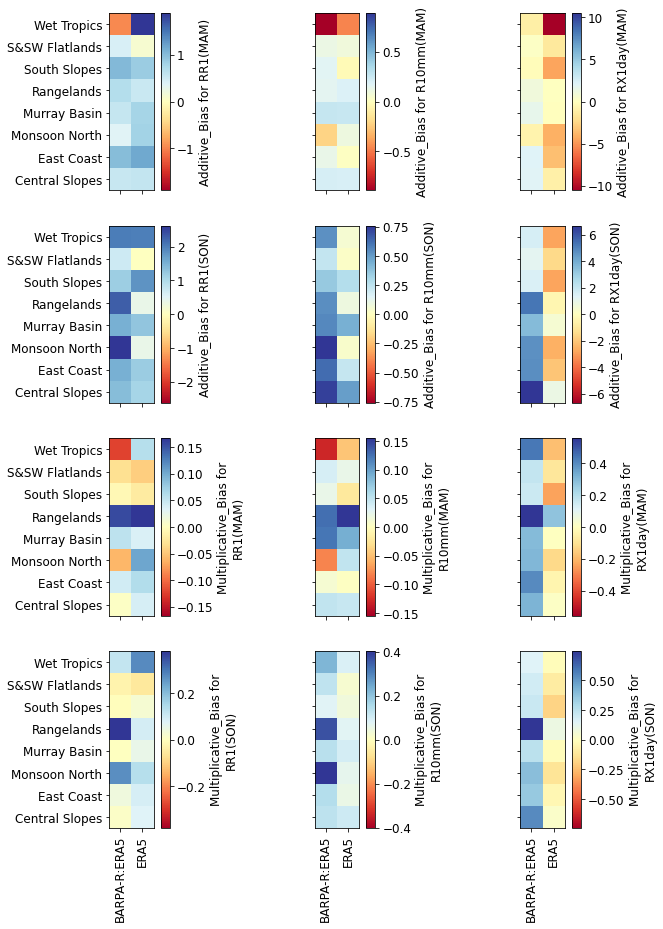

In [5]:
# Difference metrics, as per defined in lib_standards.compute_score()
#METRICS = ['Correlation:ClimMon']
METRICS = ['Additive_Bias:MAM', 'Additive_Bias:SON', 'Multiplicative_Bias:MAM', 'Multiplicative_Bias:SON']
INDEXES = ['RR1', 'R10mm', 'RX1day']
cmap_variable = 'precip'
cmap_class = 'wet_diff'

fig_xy = (len(METRICS), len(INDEXES))
fig = plt.figure(figsize=(10, 15))

for j, index in enumerate(INDEXES):
    # Prepare all the icclim data as per the setup in CONFIGURATIONS
    print("index = {:}".format(index))
    ds = prepare_data(index.lower(), apply_agcd_data_mask=True)
    
    for i, metric in enumerate(METRICS):
        #print(" --> {:}".format(metric))
        
        ds_target, metric_name, dim, clabel = apply_metric_condition(ds, index, metric)
        
        # Compute difference metrics as per the setup in CONFIGURATIONS
        scorecards = compute_difference_metrics(index, metric_name, ds_target, dim=dim)
        
        ax = plt.subplot(fig_xy[0], fig_xy[1], i*len(INDEXES)+j+1)

        add_xticklabels = False
        add_yticklabels = False
        if j == 0:
            add_yticklabels = True
        if i == len(METRICS)-1:
            add_xticklabels = True

        lib_standards.table_plot(ax, scorecards, 
                clabel=clabel,
                add_xticklabels=add_xticklabels,
                add_yticklabels=add_yticklabels,
                xrotation=90,
                cmap_variable=cmap_variable, cmap_class=cmap_class)
    
    plt.subplots_adjust(wspace=0.4)

## For the main paper: Compare temporal change in temperature-related indicator values using all the months

Doing index SU
Reading the data BARPA-R:ERA5
Reading the data AGCD
Reading the data ERA5
Regridding the data BARPA-R:ERA5 to reference grid of BARPA-R:ERA5
Regridding the data AGCD to reference grid of BARPA-R:ERA5
Regridding the data ERA5 to reference grid of BARPA-R:ERA5
Doing index TXx
Reading the data BARPA-R:ERA5
Reading the data AGCD
Reading the data ERA5
Regridding the data BARPA-R:ERA5 to reference grid of BARPA-R:ERA5
Regridding the data AGCD to reference grid of BARPA-R:ERA5
Regridding the data ERA5 to reference grid of BARPA-R:ERA5
Doing index TXn
Reading the data BARPA-R:ERA5
Reading the data AGCD
Reading the data ERA5
Regridding the data BARPA-R:ERA5 to reference grid of BARPA-R:ERA5
Regridding the data AGCD to reference grid of BARPA-R:ERA5
Regridding the data ERA5 to reference grid of BARPA-R:ERA5
Doing index TR
Reading the data BARPA-R:ERA5
Reading the data AGCD
Reading the data ERA5
Regridding the data BARPA-R:ERA5 to reference grid of BARPA-R:ERA5
Regridding the data 

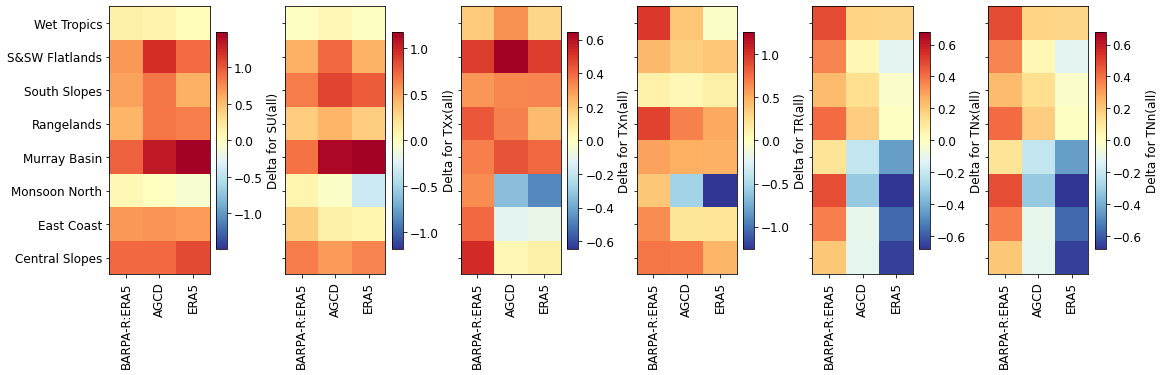

In [49]:
INDEXES = ['SU', 'TXx', 'TXn',
           'TR', 'TNx', 'TNn']
cmap_variable = 'temp'
cmap_class = 'hot_diff'
importlib.reload(lib_standards)

fig_xy = (1, len(INDEXES))
fig = plt.figure(figsize=(18, 5))
    
for j, index in enumerate(INDEXES):
    print("Doing index {:}".format(index))
    # Prepare all the icclim data as per the setup in CONFIGURATIONS
    ds = prepare_data(index.lower())

    for season in ['all']:
        ax = plt.subplot(fig_xy[0], fig_xy[1], j+1)

        ds_seas = {}
        for source in ds.keys():
            ds_seas[source] = ds[source].sel(time=ds[source].time.dt.month.isin(lib_standards.SEASONS[season]))
    
        # Compute difference metrics as per the setup in CONFIGURATIONS
        changes = compute_change_metric(index, ds_seas)

        add_xticklabels = False
        add_yticklabels = False
        
        if j == 0:
            add_yticklabels = True
        
        add_xticklabels = True
        
        lib_standards.table_plot(ax, changes, 
                clabel="Delta for {index}({season})".format(index=index, season=season),
                add_xticklabels=add_xticklabels,
                add_yticklabels=add_yticklabels,
                xrotation=90, shrink=0.8,
                cmap_variable=cmap_variable, cmap_class=cmap_class)
        
    plt.subplots_adjust(wspace=0.4)

## Compare temporal change in rainfall-related indicator values using all the months

Doing index RR1
Reading the data BARPA-R:ERA5
Reading the data AGCD
Reading the data ERA5
Regridding the data BARPA-R:ERA5 to reference grid of BARPA-R:ERA5
Regridding the data AGCD to reference grid of BARPA-R:ERA5
Regridding the data ERA5 to reference grid of BARPA-R:ERA5
Doing index R10mm
Reading the data BARPA-R:ERA5
Reading the data AGCD
Reading the data ERA5
Regridding the data BARPA-R:ERA5 to reference grid of BARPA-R:ERA5
Regridding the data AGCD to reference grid of BARPA-R:ERA5
Regridding the data ERA5 to reference grid of BARPA-R:ERA5
Doing index RX1day
Reading the data BARPA-R:ERA5
Reading the data AGCD
Reading the data ERA5
Regridding the data BARPA-R:ERA5 to reference grid of BARPA-R:ERA5
Regridding the data AGCD to reference grid of BARPA-R:ERA5
Regridding the data ERA5 to reference grid of BARPA-R:ERA5


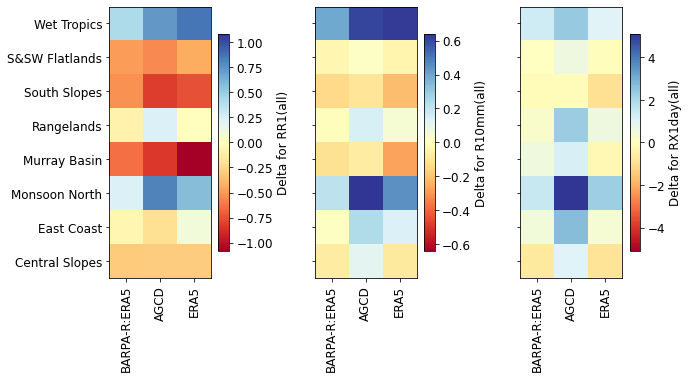

In [70]:
INDEXES = ['RR1', 'R10mm', 'RX1day']
cmap_variable = 'precip'
cmap_class = 'wet_diff'
importlib.reload(lib_standards)

fig_xy = (1, len(INDEXES))
fig = plt.figure(figsize=(10, 5))
    
for j, index in enumerate(INDEXES):
    print("Doing index {:}".format(index))
    # Prepare all the icclim data as per the setup in CONFIGURATIONS
    ds = prepare_data(index.lower(), apply_agcd_data_mask=True)

    for season in ['all']:
        ax = plt.subplot(fig_xy[0], fig_xy[1], j+1)

        ds_seas = {}
        for source in ds.keys():
            ds_seas[source] = ds[source].sel(time=ds[source].time.dt.month.isin(lib_standards.SEASONS[season]))
    
        # Compute difference metrics as per the setup in CONFIGURATIONS
        changes = compute_change_metric(index, ds_seas)

        add_xticklabels = False
        add_yticklabels = False
        
        if j == 0:
            add_yticklabels = True
        
        add_xticklabels = True
        
        lib_standards.table_plot(ax, changes, 
                clabel="Delta for {index}({season})".format(index=index, season=season),
                add_xticklabels=add_xticklabels,
                add_yticklabels=add_yticklabels,
                xrotation=90, shrink=0.8,
                cmap_variable=cmap_variable, cmap_class=cmap_class)
        
    plt.subplots_adjust(wspace=0.4)

## Compare temporal change in temperature-related indicator values for different seasons (Supplementary)

Doing index SU
Reading the data BARPA-R:ERA5
Reading the data AGCD
Reading the data ERA5
Regridding the data BARPA-R:ERA5 to reference grid of BARPA-R:ERA5
Regridding the data AGCD to reference grid of BARPA-R:ERA5
Regridding the data ERA5 to reference grid of BARPA-R:ERA5
Doing index TXx
Reading the data BARPA-R:ERA5
Reading the data AGCD
Reading the data ERA5
Regridding the data BARPA-R:ERA5 to reference grid of BARPA-R:ERA5
Regridding the data AGCD to reference grid of BARPA-R:ERA5
Regridding the data ERA5 to reference grid of BARPA-R:ERA5
Doing index TXn
Reading the data BARPA-R:ERA5
Reading the data AGCD
Reading the data ERA5
Regridding the data BARPA-R:ERA5 to reference grid of BARPA-R:ERA5
Regridding the data AGCD to reference grid of BARPA-R:ERA5
Regridding the data ERA5 to reference grid of BARPA-R:ERA5
Doing index TR
Reading the data BARPA-R:ERA5
Reading the data AGCD
Reading the data ERA5
Regridding the data BARPA-R:ERA5 to reference grid of BARPA-R:ERA5
Regridding the data 

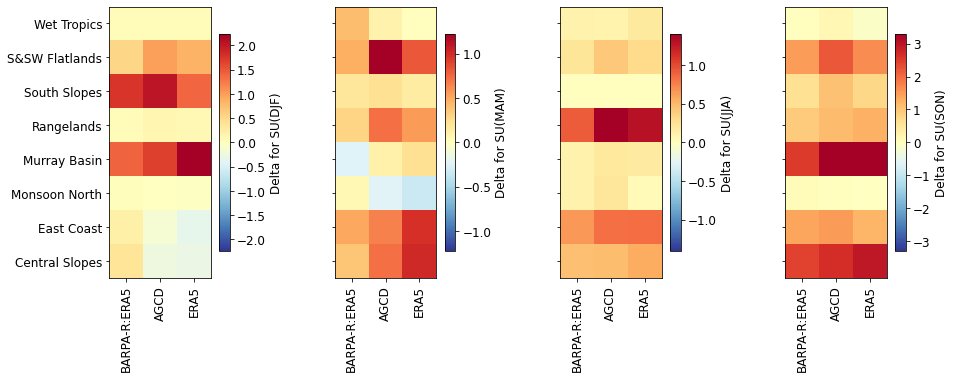

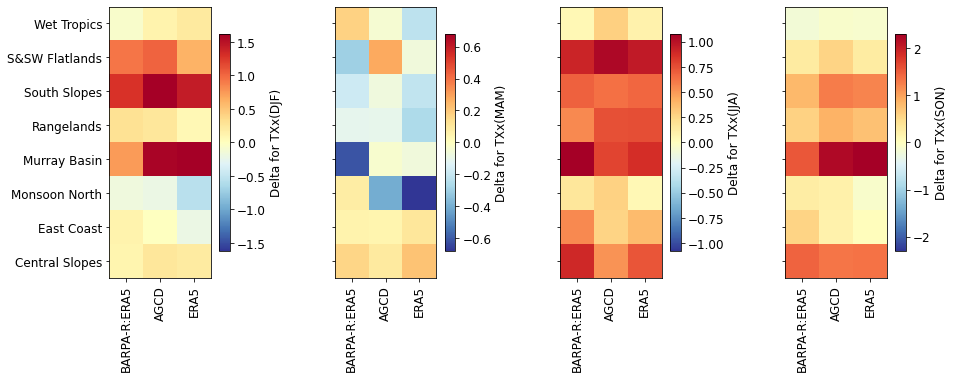

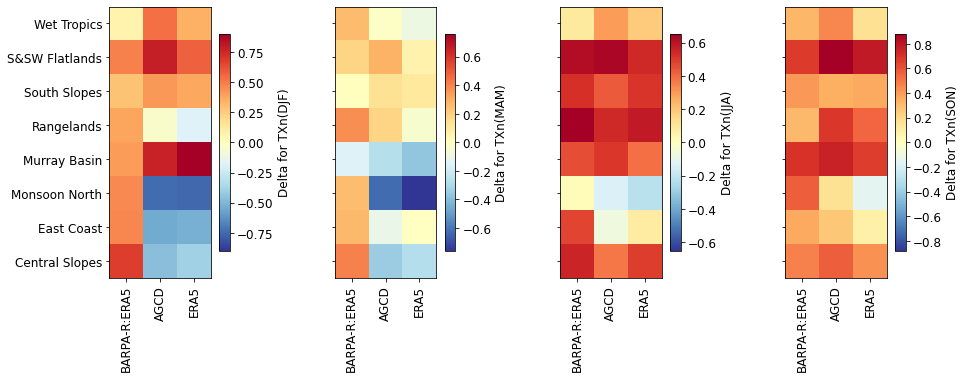

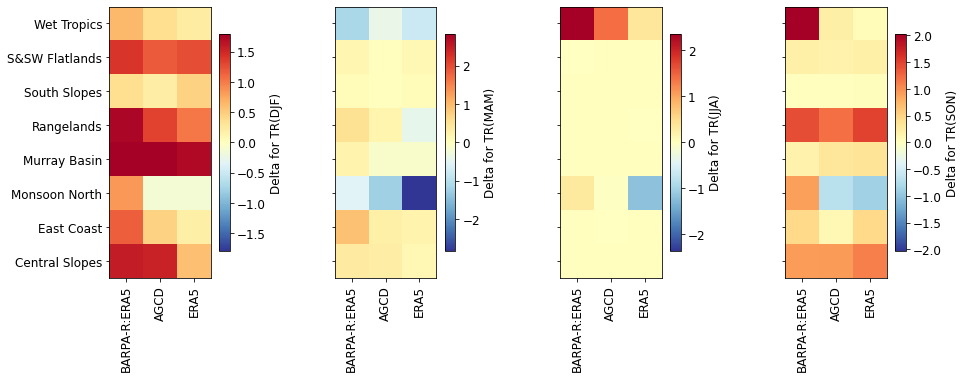

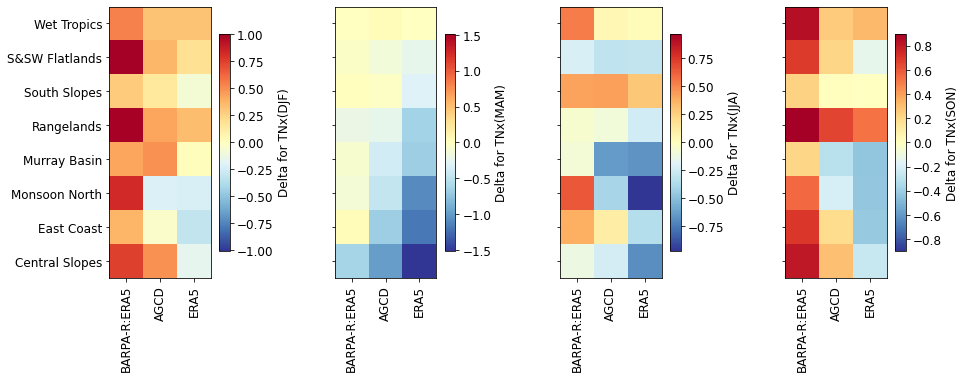

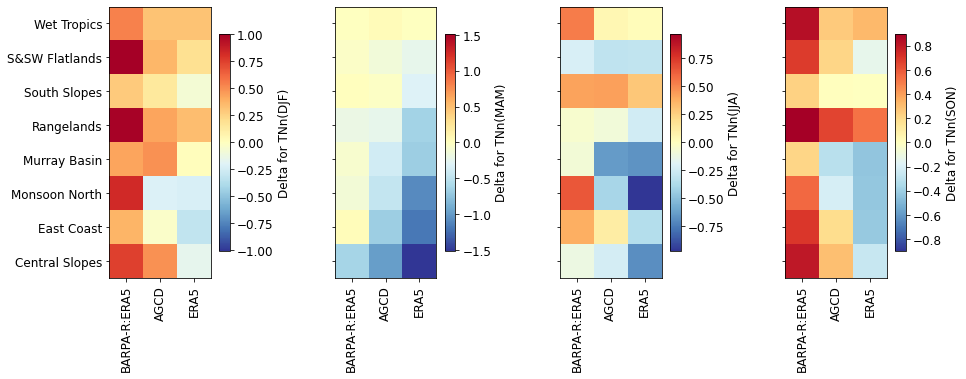

In [55]:
INDEXES = ['SU', 'TXx', 'TXn',
           'TR', 'TNx', 'TNn']
cmap_variable = 'temp'
cmap_class = 'hot_diff'
importlib.reload(lib_standards)
    
for j, index in enumerate(INDEXES):
    print("Doing index {:}".format(index))
    # Prepare all the icclim data as per the setup in CONFIGURATIONS
    ds = prepare_data(index.lower())

    fig_xy = (1, 4)
    fig = plt.figure(figsize=(15, 5))

    for i, season in enumerate(['DJF', 'MAM', 'JJA', 'SON']):
        ax = plt.subplot(fig_xy[0], fig_xy[1], i+1)

        ds_seas = {}
        for source in ds.keys():
            ds_seas[source] = ds[source].sel(time=ds[source].time.dt.month.isin(lib_standards.SEASONS[season]))
    
        # Compute difference metrics as per the setup in CONFIGURATIONS
        changes = compute_change_metric(index, ds_seas)

        add_xticklabels = False
        add_yticklabels = False
        
        if i == 0:
            add_yticklabels = True
        if j == len(INDEXES)-1:
            add_xticklabels = True
        
        add_xticklabels = True
        
        lib_standards.table_plot(ax, changes, 
                clabel="Delta for {index}({season})".format(index=index, season=season),
                add_xticklabels=add_xticklabels,
                add_yticklabels=add_yticklabels,
                xrotation=90, shrink=0.8,
                cmap_variable=cmap_variable, cmap_class=cmap_class)
        
    plt.subplots_adjust(wspace=0.4)

## Compare temporal change in rainfall-related indicator values for different seasons (Supplementary)

Doing index RR1
Reading the data BARPA-R:ERA5
Reading the data AGCD
Reading the data ERA5
Regridding the data BARPA-R:ERA5 to reference grid of BARPA-R:ERA5
Regridding the data AGCD to reference grid of BARPA-R:ERA5
Regridding the data ERA5 to reference grid of BARPA-R:ERA5
Doing index R10mm
Reading the data BARPA-R:ERA5
Reading the data AGCD
Reading the data ERA5
Regridding the data BARPA-R:ERA5 to reference grid of BARPA-R:ERA5
Regridding the data AGCD to reference grid of BARPA-R:ERA5
Regridding the data ERA5 to reference grid of BARPA-R:ERA5
Doing index RX1day
Reading the data BARPA-R:ERA5
Reading the data AGCD
Reading the data ERA5
Regridding the data BARPA-R:ERA5 to reference grid of BARPA-R:ERA5
Regridding the data AGCD to reference grid of BARPA-R:ERA5
Regridding the data ERA5 to reference grid of BARPA-R:ERA5


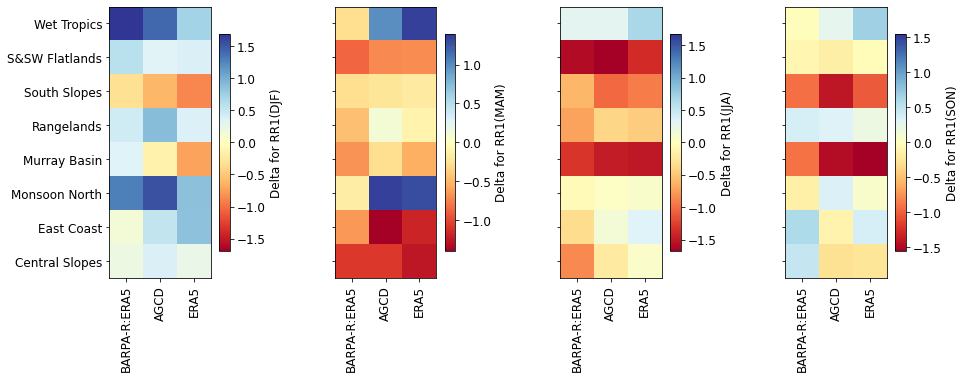

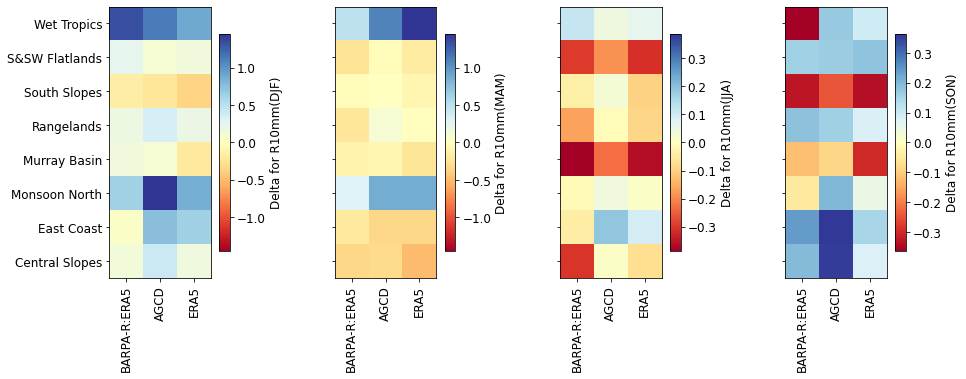

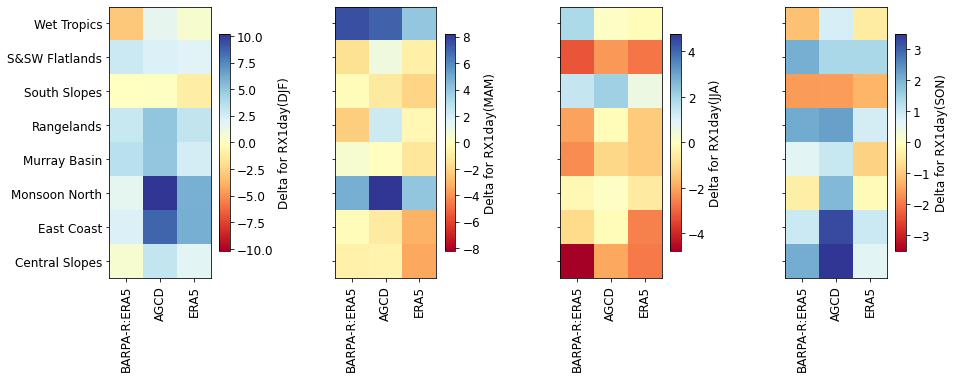

In [71]:
INDEXES = ['RR1', 'R10mm', 'RX1day']
cmap_variable = 'precip'
cmap_class = 'wet_diff'
importlib.reload(lib_standards)
    
for j, index in enumerate(INDEXES):
    print("Doing index {:}".format(index))
    # Prepare all the icclim data as per the setup in CONFIGURATIONS
    ds = prepare_data(index.lower(), apply_agcd_data_mask=True)

    fig_xy = (1, 4)
    fig = plt.figure(figsize=(15, 5))

    for i, season in enumerate(['DJF', 'MAM', 'JJA', 'SON']):
        ax = plt.subplot(fig_xy[0], fig_xy[1], i+1)

        ds_seas = {}
        for source in ds.keys():
            ds_seas[source] = ds[source].sel(time=ds[source].time.dt.month.isin(lib_standards.SEASONS[season]))
    
        # Compute difference metrics as per the setup in CONFIGURATIONS
        changes = compute_change_metric(index, ds_seas)

        add_xticklabels = False
        add_yticklabels = False
        
        if i == 0:
            add_yticklabels = True
        if j == len(INDEXES)-1:
            add_xticklabels = True
        
        add_xticklabels = True
        
        lib_standards.table_plot(ax, changes, 
                clabel="Delta for {index}({season})".format(index=index, season=season),
                add_xticklabels=add_xticklabels,
                add_yticklabels=add_yticklabels,
                xrotation=90, shrink=0.8,
                cmap_variable=cmap_variable, cmap_class=cmap_class)
        
    plt.subplots_adjust(wspace=0.4)

# Check icclim data files

In [29]:
indir = '/g/data/ia39/australian-climate-service/test-data/CORDEX-CMIP6/indices/AUS-15/BOM/ECMWF-ERA5/evaluation/r1i1p1f1/BOM-BARPA-R/v1/climdex'
files = glob.glob(os.path.join(indir, '*', '*_month_*.nc'))

In [119]:
for file in files:
    ds = xr.open_dataset(file)
    variable = [v for v in list(ds.keys()) if not 'time' in v][0]
    vmin = ds.min().compute()[variable].values
    vmax = ds.max().compute()[variable].values
    nnan = ds.isnull().sum().compute()[variable].values
    print("{:}, vmin={:}, vmax={:}, nnan={:}".format(variable, vmin, vmax, nnan))

PRCPTOT, vmin=0.0, vmax=10448.078066755079, nnan=0
TXx, vmin=-0.186859130859375, vmax=50.924713134765625, nnan=0
RX5day, vmin=0.0, vmax=5339.404955506325, nnan=0
SDII, vmin=1.0000079870224, vmax=552.9766845703125, nnan=6145263
RX1day, vmin=0.0, vmax=1791.4384765625, nnan=0
TR, vmin=0, vmax=31, nnan=0
TN, vmin=-17.180389404296875, vmax=30.623626708984375, nnan=0
TNx, vmin=-36.812591552734375, vmax=30.129547119140625, nnan=0
TXn, vmin=-11.673919677734375, vmax=42.855865478515625, nnan=0
R20mm, vmin=0, vmax=31, nnan=0
CDD, vmin=0.0, vmax=461.0, nnan=5910438
ID, vmin=0, vmax=31, nnan=0
CFD, vmin=0.0, vmax=204.0, nnan=2977
R10mm, vmin=0, vmax=31, nnan=0
RR1, vmin=0, vmax=31, nnan=0
FD, vmin=0, vmax=31, nnan=0
CSU, vmin=0.0, vmax=15341.0, nnan=81212109
CWD, vmin=0.0, vmax=745.0, nnan=365706
RR, vmin=0.0, vmax=10448.078066755079, nnan=0
SU, vmin=0, vmax=31, nnan=0
TX, vmin=-5.057373046875, vmax=45.0655517578125, nnan=0
TNn, vmin=-36.812591552734375, vmax=30.129547119140625, nnan=0
